In [12]:
import gym
import torch
import numpy as np
import matplotlib.pyplot as plt
import collections
import random

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)
    
    def add(self, state, action, reward, next_state, nonterminal):
        self.buffer.append((state, action, reward, next_state, nonterminal))

    def sample(self, batch_size):
        transitions = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, nonterminals = zip(*transitions)
        return states, actions, rewards, next_states, nonterminals
    
    def size(self):
        return len(self.buffer)
    

class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound):
        super().__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.mu = torch.nn.Linear(hidden_dim, action_dim)
        self.std = torch.nn.Linear(hidden_dim, action_dim)
        self.action_bound = action_bound
    
    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        mu = self.mu(x)
        std = torch.nn.functional.softplus(self.std(x))
        dist = torch.distributions.Normal(mu, std)
        normal_sample = dist.rsample()
        log_prob = dist.log_prob(normal_sample)
        action = torch.tanh(normal_sample)
        log_prob = log_prob - torch.log(1-torch.tanh(action).pow(2) + 1e-7)
        action = action * self.action_bound
        return action, log_prob

class QValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super().__init__()
        self.fc1 = torch.nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc_out = torch.nn.Linear(hidden_dim, 1)

    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = self.fc_out(x)
        return x
    
class SAC:
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound, actor_lr, critic_lr, alpha_lr, target_entropy, tau, gamma, device):
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim, action_bound).to(device)
        self.critic1 = QValueNet(state_dim, hidden_dim, action_dim).to(device)
        self.critic2 = QValueNet(state_dim, hidden_dim, action_dim).to(device)
        self.target_critic1 = QValueNet(state_dim, hidden_dim, action_dim).to(device)
        self.target_critic2 = QValueNet(state_dim, hidden_dim, action_dim).to(device)
        self.target_critic1.load_state_dict(self.critic1.state_dict())
        self.target_critic2.load_state_dict(self.critic2.state_dict())
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),lr=actor_lr)
        self.critic1_optimizer = torch.optim.Adam(self.critic1.parameters(),lr=critic_lr)
        self.critic2_optimizer = torch.optim.Adam(self.critic2.parameters(),lr=critic_lr)
        self.log_alpha = torch.tensor(np.log(0.01),dtype=torch.float)
        self.log_alpha.requires_grad = True
        self.log_alpha_optimizer = torch.optim.Adam([self.log_alpha],lr=alpha_lr)

        self.target_entropy = target_entropy
        self.tau = tau
        self.gamma = gamma
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        action, log_prob = self.actor(state)
        return [action.item()]
    
    def calc_target(self, rewards, next_states, nonterminals):
        next_actions, log_probs = self.actor(next_states)
        entropy = -log_probs
        q1_value = self.target_critic1(next_states, next_actions)
        q2_value = self.target_critic2(next_states, next_actions)
        next_value = torch.min(q1_value,q2_value)+self.log_alpha.exp()*entropy
        td_target = rewards + self.gamma * next_value * nonterminals
        return td_target
    
    def soft_update(self, net, target_net):
        for target_param, param in zip(target_net.parameters(), net.parameters()):
            target_param.data.copy_(target_param.data * (1-self.tau) + param.data * self.tau)
    
    def update(self, states, actions, rewards, next_states, nonterminals):
        states = torch.tensor(states, dtype=torch.float).to(self.device)
        actions = torch.tensor(actions, dtype=torch.float).view(-1,1).to(self.device)
        rewards = torch.tensor(rewards, dtype=torch.float).view(-1,1).to(self.device)
        next_states = torch.tensor(next_states, dtype=torch.float).to(self.device)
        nonterminals = torch.tensor(nonterminals, dtype=torch.float).view(-1,1).to(self.device)
        rewards = (rewards + 8.0)/8.0

        td_target = self.calc_target(rewards, next_states, nonterminals)
        critic1_loss = torch.nn.functional.mse_loss(self.critic1(states,actions), td_target.detach()).mean()
        critic2_loss = torch.nn.functional.mse_loss(self.critic2(states,actions), td_target.detach()).mean()

        self.critic1_optimizer.zero_grad()
        critic1_loss.backward()
        self.critic1_optimizer.step()
        
        self.critic2_optimizer.zero_grad()
        critic2_loss.backward()
        self.critic2_optimizer.step()

        new_actions, log_prob = self.actor(states)
        entropy = - log_prob
        q1_value = self.critic1(states, new_actions)
        q2_value = self.critic2(states, new_actions)
        actor_loss = torch.mean(-self.log_alpha.exp()*entropy - torch.min(q1_value, q2_value))
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        alpha_loss = torch.mean((entropy-self.target_entropy).detach()*self.log_alpha.exp())
        self.log_alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.log_alpha_optimizer.step()

        self.soft_update(self.critic1, self.target_critic1)
        self.soft_update(self.critic2, self.target_critic2)
        




actor_lr = 3e-4
critic_lr = 3e-3
alpha_lr = 3e-4

hidden_dim = 128
gamma = 0.98
tau = 0.005
buffer_size = 10000
minimal_size = 1000
batch_size = 64

device = torch.device("cuda") if torch.cuda.is_available () else torch.device("cpu")#torch.device("cpu") #
env_name = "Pendulum-v1"

env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
action_bound = env.action_space.high[0]
target_entropy=-env.action_space.shape[0]
env.close()
    
def reset_seed():
    random.seed(0)
    np.random.seed(0)
    torch.manual_seed(0)

def train(agent, num_episodes):
    reset_seed()
    replay_buffer = ReplayBuffer(buffer_size)
    reward_stat = np.zeros(num_episodes)
    env = gym.make(env_name)
    for episode in range(num_episodes):
        state, info = env.reset(seed=0)
        total_reward = 0
        while True:
            action = agent.take_action(state)
            next_state, reward, terminated, truncated, info = env.step(action)
            replay_buffer.add(state, action, reward, next_state, not terminated)
            state = next_state
            total_reward += reward
            if replay_buffer.size() > minimal_size:
                states, actions, rewards, next_states, terminateds = replay_buffer.sample(batch_size)
                agent.update(states, actions, rewards, next_states, terminateds)
            if terminated or truncated:
                break
        if episode*10 % num_episodes == 0:
            print("episode:", episode, "total_reward:",total_reward)
        reward_stat[episode] = total_reward
    env.close()
    return reward_stat

def test(agent, num_episodes):
    env = gym.make(env_name,render_mode="human")
    for episode in range(num_episodes):
        state, info = env.reset()
        total_reward = 0
        while True:
            action = agent.take_action(state)
            next_state, reward, terminated, truncated, info = env.step(action)
            state = next_state
            total_reward += reward
            if terminated or truncated:
                break
        #print("episode:", episode, "total_reward:",total_reward)
    env.close()


def moving_average(nums, n):
    beta = 1 - 1.0/n
    alpha = 1.0 - beta
    avg = nums[0]
    res = np.zeros_like(nums)
    for n in range(len(nums)):
        avg = avg * beta + nums[n]*alpha
        res[n] = avg
    return res

episode: 0 total_reward: -1095.4345402874067
episode: 10 total_reward: -1438.765419465479
episode: 20 total_reward: -1601.8332876767486
episode: 30 total_reward: -954.6242891725664
episode: 40 total_reward: -263.1274517322356
episode: 50 total_reward: -269.18290667686034
episode: 60 total_reward: -131.30083534307417
episode: 70 total_reward: -131.39447814874057
episode: 80 total_reward: -126.69717403575048
episode: 90 total_reward: -128.28715288388187


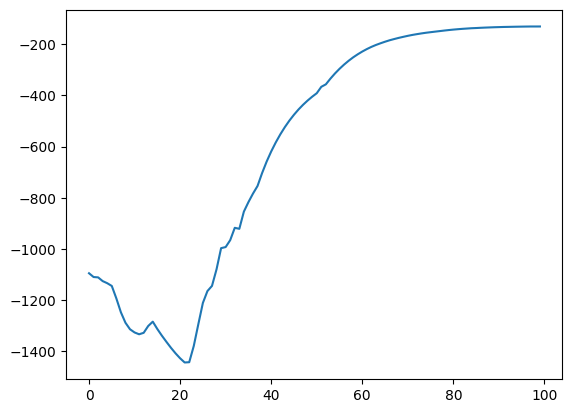

In [13]:
num_episodes = 100
reset_seed()
agent1 = SAC(state_dim, hidden_dim, action_dim, action_bound, actor_lr, critic_lr, alpha_lr, target_entropy, tau, gamma, device)
reward_stat1  = train(agent1, num_episodes)
plt.plot(range(len(reward_stat1)), moving_average(reward_stat1,10))
plt.show()
